#### Use case 1 - Facial Recognition

Task - Supervised machine learning model that is able to predict the name of the person given image

In [1]:
# olivetti face dataset
from sklearn.datasets import fetch_lfw_people

# feature extraction modules
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# feature scaling module
from sklearn.preprocessing import StandardScaler

# standard python modules
from time import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# selection models
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# machine learning modules
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


In [2]:
# Ace included this step to ignore FutureWarnings 
# source - https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/
# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# load the dataset
# the optional parameter: min_faces_per_person: 
# will only retain pictures of people that have at least min_faces_per_person different pictures.
# the optional parameter: resize is the ratio used to resize the each face picture.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [4]:
# introspect the images arrays to find the shapes (for plotting)
# Notice that we've 1288 samples each of height = 50 pixels, width = 37 pixels

n_samples, h, w = lfw_people.images.shape
n_samples, h, w

(1288, 50, 37)

In [5]:
# for machine learning we use the data directly (as relative pixel positions info is ignored by this model)
# Note that the features = 1850 <= h x w = 50 x 37 (a row of 1850 columns = one face)
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]
print(n_features)

1850


In [6]:
X.shape

(1288, 1850)

Data Exploration

'Hugo Chavez'

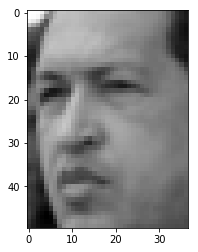

In [7]:
# plot one of the faces

plt.imshow(X[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

'Hugo Chavez'

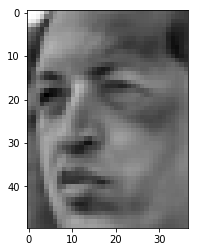

In [8]:
# plot one of the faces after applying a scaling modujle
from sklearn.preprocessing import StandardScaler

plt.imshow(StandardScaler().fit_transform(X)[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

In [9]:
# the label to predict is the id of the person
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("\tn_samples: %d" % n_samples)
print ("\tn_features: %d" % n_features)
print ("\tn_classes: %d" % n_classes)

Total dataset size:
	n_samples: 1288
	n_features: 1850
	n_classes: 7


In [10]:
# let's split our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [11]:
"""
Compute a PCA (eigenfaces) on the face dataset 

from sklearn docs:
The optional parameter whiten=True makes it possible to project the data onto the singular space 
while scaling each component to unit variance. This is often useful if the models down-stream make strong 
assumptions on the isotropy of the signal: this is for example the case for 
Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.
"""

# instantiate the PCA module
pca = PCA(n_components=200, whiten=True)

# create a pipeline called preprocessing that will scale data and then apply PCA
preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca)])

print ("Extracting the top %d eigenfaces from %d faces" % (200, X_train.shape[0]))

# fit the pipeline to the training set
preprocessing.fit(X_train)

# grab the PCA from the pipeline
extracted_pca = preprocessing.steps[1][1]

Extracting the top 200 eigenfaces from 966 faces


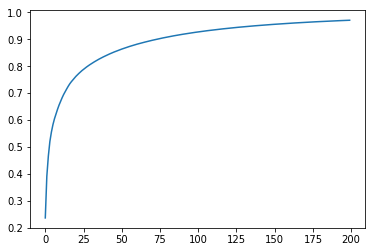

In [12]:
# Scree Plot

plt.plot(np.cumsum(extracted_pca.explained_variance_ratio_))

# starting at 100 components captures over 90% of the variance compared to the 1,850 original features

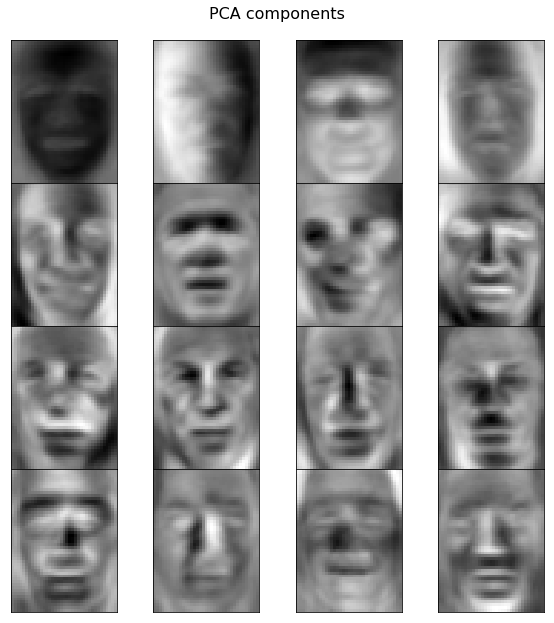

In [13]:
comp = extracted_pca.components_
image_shape = (h, w)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
plot_gallery('PCA components', comp[:16], 4,4)

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints a more readable confusion matrix with heat labels and options for noramlization
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
# Included this line as it is missing in the book and original source code by author
logreg = LogisticRegression()

0.8136645962732919 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.68      0.70        19
     Colin Powell       0.85      0.71      0.77        55
  Donald Rumsfeld       0.62      0.72      0.67        25
    George W Bush       0.88      0.91      0.89       142
Gerhard Schroeder       0.79      0.84      0.81        31
      Hugo Chavez       0.87      0.81      0.84        16
       Tony Blair       0.71      0.71      0.71        34

        micro avg       0.81      0.81      0.81       322
        macro avg       0.78      0.77      0.77       322
     weighted avg       0.82      0.81      0.81       322

None
43.5 seconds to grid search and predict the test set


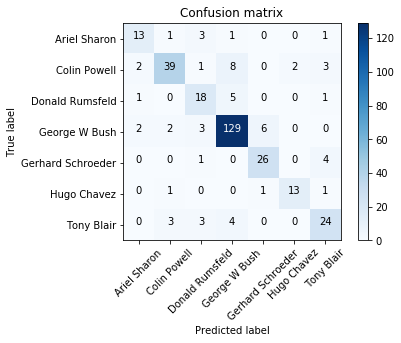

In [16]:
# fit without using PCA to see what the difference will be
t0 = time()

param_grid = {'C': [1e-2, 1e-1,1e0,1e1, 1e2]}
clf = GridSearchCV(logreg, param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)

print (accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print (classification_report(y_test, y_pred, target_names=target_names))
print (plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names))
print (round((time() - t0), 1), "seconds to grid search and predict the test set")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7360248447204969 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.53      0.54        19
     Colin Powell       0.72      0.65      0.69        55
  Donald Rumsfeld       0.65      0.52      0.58        25
    George W Bush       0.78      0.88      0.83       142
Gerhard Schroeder       0.76      0.71      0.73        31
      Hugo Chavez       0.71      0.62      0.67        16
       Tony Blair       0.70      0.62      0.66        34

        micro avg       0.74      0.74      0.74       322
        macro avg       0.70      0.65      0.67       322
     weighted avg       0.73      0.74      0.73       322

None
64.2 seconds to grid search and predict the test set


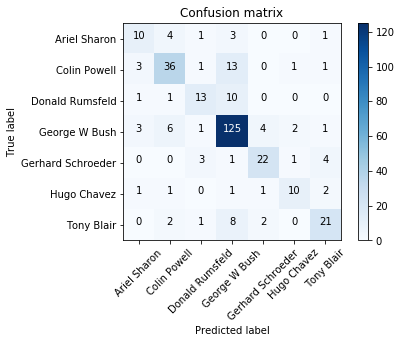

In [17]:
# fit with using PCA to see what the difference will be
t0 = time()

face_pipeline = Pipeline(steps=[('PCA', PCA(n_components=200)), ('logistic', logreg)])

pipe_param_grid = {'logistic__C': [1e-2, 1e-1,1e0,1e1, 1e2]}
clf = GridSearchCV(face_pipeline, pipe_param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)

print (accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print (classification_report(y_test, y_pred, target_names=target_names))
print (plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names))
print (round((time() - t0), 1), "seconds to grid search and predict the test set")

In [18]:
# get a list of predicted names and true names to plot with faces in test set
prediction_titles = [title(y_pred, y_test, target_names, i) 
                     for i in range(y_pred.shape[0])]

# splot a sample of the test set with predicted and true names
plot_gallery(X_test, prediction_titles, h, w)

NameError: name 'title' is not defined

In [ ]:
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model,           # the model to grid search
                        params,          # the parameter set to try 
                        error_score=0.)  # if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid.fit(X, y)           # fit the model and parameters
    # our classical metric for performance
    print ("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print ("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print ("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print ("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

In [ ]:
# Create a larger pipeline to gridsearch
face_params = {'logistic__C':[1e-2, 1e-1, 1e0, 1e1, 1e2], 
               'preprocessing__pca__n_components':[100, 150, 200, 250, 300],
               'preprocessing__pca__whiten':[True, False],
               'preprocessing__lda__n_components':range(1, 7)  
               # [1, 2, 3, 4, 5, 6] recall the max allowed is n_classes-1
              }

pca = PCA()
lda = LinearDiscriminantAnalysis()

preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca), ('lda', lda)])

logreg = LogisticRegression()
face_pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('logistic', logreg)])

get_best_model_and_accuracy(face_pipeline, face_params, X, y)